In [103]:
%matplotlib inline
import sys
sys.path.insert(0, '../')
from skimage.io import imread
import tensorflow as tf
import utils as utils
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.transform import resize

## For bug fix
import importlib
importlib.reload(utils)

<module 'utils' from '..\\utils.py'>

### Transfer data to tfrecords

Set the path to low-resolution (input) and high-resolution images (output)

In [2]:
PATH_TO_HR = '../test_data/high_resolution/'
PATH_TO_LR = '../test_data/low_resolution/'
SAVE_DIR = './test_save'
NAME = 'valid_data'

Convert the images to `*.tfrecords` files. Note that each image could have different sizes.

In [3]:
test_data_obj = utils.Data(PATH_TO_LR, PATH_TO_HR, SAVE_DIR, NAME)
input_list, output_list = test_data_obj.get_files()
test_data_obj.convert_to_tfrecord(input_list, output_list)

Writing ./test_save\valid_data.tfrecords
Images are transfered and stored as ./test_save\valid_data.tfrecords


### Validate the transfer

Lets decode the images and plot one pair.

In [4]:
filename = tf.constant(os.path.join(SAVE_DIR, NAME+'.tfrecords'))
dataset = tf.contrib.data.TFRecordDataset(filename)

def _parse_function(example_proto):
    features = {'in_shape': tf.FixedLenFeature([], tf.string),
                'out_shape': tf.FixedLenFeature([], tf.string),
                'in_image_raw': tf.FixedLenFeature([], tf.string),
                'out_image_raw': tf.FixedLenFeature([], tf.string)}
    parsed_features = tf.parse_single_example(example_proto, features)
    in_shape = tf.decode_raw(parsed_features["in_shape"], tf.int32)
    in_image = tf.decode_raw(parsed_features["in_image_raw"], tf.int32)
    out_shape = tf.decode_raw(parsed_features["out_shape"], tf.int32)
    out_image = tf.decode_raw(parsed_features["out_image_raw"], tf.int32)
    
    in_image = tf.reshape(in_image, in_shape)
    out_image = tf.reshape(out_image, out_shape)
    
    return in_image, out_image

In [5]:
dataset = dataset.map(_parse_function)
batched_dataset = dataset.batch(1)          # Since the images has different shapes, the batch set to 1.
iterator = batched_dataset.make_one_shot_iterator()
next_element = iterator.get_next()
sess = tf.InteractiveSession()
out = sess.run(next_element)
image_tf = out[0].squeeze()

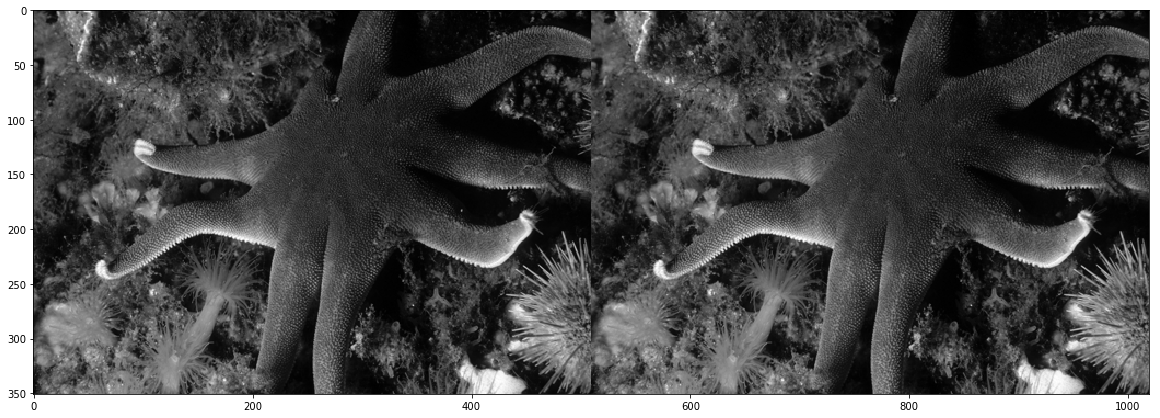

In [6]:
image_1 = imread('../test_data/low_resolution/0001.png')
plt.figure(figsize=(20, 40))
plt.imshow(np.concatenate([image_1, image_tf], axis=1), cmap='gray')

### Test the data preprocessing
Define another function to perform the preprocessing by transform the `dataset`.

In [97]:
CROP_SIZE_IN = 64
CROP_SIZE_OUT = CROP_SIZE_IN * 4
CHANNEL_IN = 1
def _preprocessing_function(image_in, image_out):
    
    in_shape = tf.shape(image_in)
    h_offset = tf.random_uniform([], minval=0, maxval=in_shape[0] - CROP_SIZE_IN, dtype=tf.int32)
    w_offset = tf.random_uniform([], minval=0, maxval=in_shape[1] - CROP_SIZE_IN, dtype=tf.int32)
    box_start = tf.stack([h_offset, w_offset, tf.constant(0)])
    box_size = tf.constant((CROP_SIZE_IN, CROP_SIZE_IN, CHANNEL_IN))
    cropped_image_in = tf.slice(image_in, box_start, box_size)

    out_shape = tf.shape(image_out)
    h_offset = tf.scalar_mul(4, h_offset)
    w_offset = tf.scalar_mul(4, w_offset)  
    box_start = tf.stack([h_offset, w_offset, tf.constant(0)])
    box_size = tf.constant((CROP_SIZE_OUT, CROP_SIZE_OUT, CHANNEL_IN))
    cropped_image_out = tf.slice(image_out, box_start, box_size)

    return cropped_image_in, cropped_image_out

C:\Users\hzhang\AppData\Local\Continuum\Anaconda3\envs\tf\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


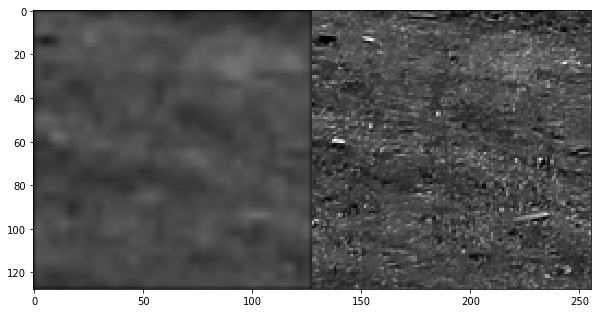

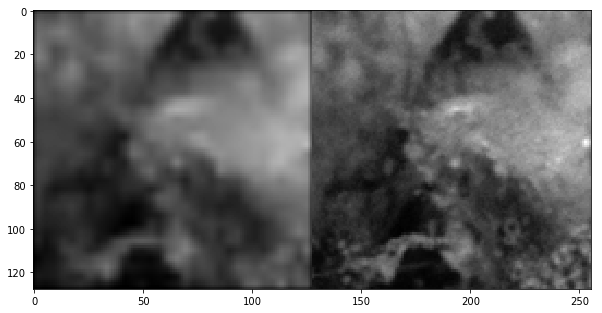

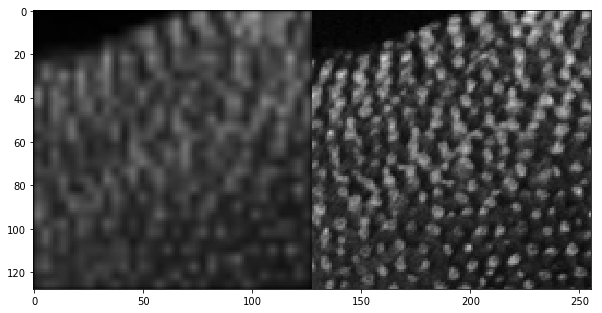

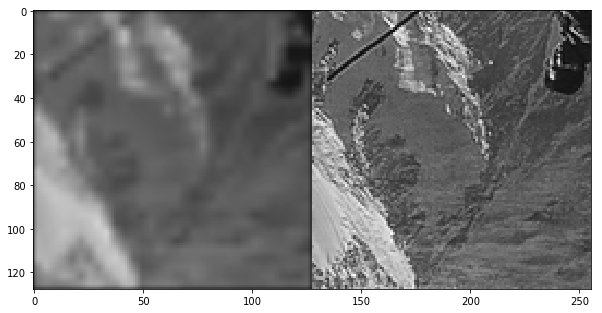

In [117]:
dataset = tf.contrib.data.TFRecordDataset(filename)
dataset = dataset.map(_parse_function)
dataset = dataset.map(_preprocessing_function)
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(1)
dataset = dataset.repeat()
iterator = dataset.make_one_shot_iterator()
next_item = iterator.get_next()
sess = tf.InteractiveSession()
for _ in range(4):
    cropped_image_in, cropped_image_out = map(lambda x: x.squeeze(), sess.run(next_item))
    cropped_image_in = resize(cropped_image_in, cropped_image_out.shape)
    cropped_image_out = resize(cropped_image_out, cropped_image_out.shape)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.concatenate([cropped_image_in, cropped_image_out], axis=1), cmap='gray')